<a href="https://colab.research.google.com/github/ManasaKagithi/CKD-detection-ML/blob/main/ckd_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [54]:
# Importing the data
data = pd.read_csv(r'/content/kidney_disease.csv')
data=data.drop(columns='id',axis=1)

In [55]:
# Convert problematic columns to numeric
for col in ['pcv', 'wc', 'rc']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [56]:
# Clean inconsistent strings in categorical data
data['dm'] = data['dm'].replace({'\tno': 'no', '\tyes': 'yes', ' yes': 'yes'})
data['cad'] = data['cad'].replace('\tno', 'no')
data['classification'] = data['classification'].replace('ckd\t', 'ckd')

In [57]:
# Encode target variable
data['classification'] = data['classification'].map({'ckd': 1, 'notckd': 0})

In [58]:
# Identify column types
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
num_cols = [col for col in data.columns if data[col].dtype in ['float64', 'int64']]

In [59]:
# Fill numerical missing values using random sampling
for col in num_cols:
    if data[col].isnull().sum() > 0:
        sampled = data[col].dropna().sample(data[col].isnull().sum(), random_state=42)
        sampled.index = data[data[col].isnull()].index
        data.loc[data[col].isnull(), col] = sampled

In [60]:
# Fill categorical missing values using mode
for col in cat_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

In [61]:
# Encode categorical features
le = LabelEncoder()
for col in cat_cols:
    data[col] = le.fit_transform(data[col])


In [62]:
#Add Unique Feature: Renal Burden Index (RBI)
data['rbi'] = (data['bu'] + data['sc'] + data['bgr']) / (data['hemo'] * data['sg'])
data['rbi'] = data['rbi'].replace([np.inf, -np.inf], np.nan)
data['rbi'] = data['rbi'].fillna(data['rbi'].median())

In [63]:
# Define features and target
X = data.drop(columns='classification')
y = data['classification']


In [64]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [65]:
# Train Random Forest (best performing model)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [68]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
accuracy, feature_importance.head(10), pd.DataFrame(report).T

(1.0,
 hemo    0.183657
 sg      0.183420
 rbi     0.161870
 sc      0.107341
 al      0.099979
 pcv     0.082180
 rc      0.029750
 dm      0.029398
 bgr     0.021131
 htn     0.020466
 dtype: float64,
               precision  recall  f1-score  support
 0                   1.0     1.0       1.0     28.0
 1                   1.0     1.0       1.0     52.0
 accuracy            1.0     1.0       1.0      1.0
 macro avg           1.0     1.0       1.0     80.0
 weighted avg        1.0     1.0       1.0     80.0)

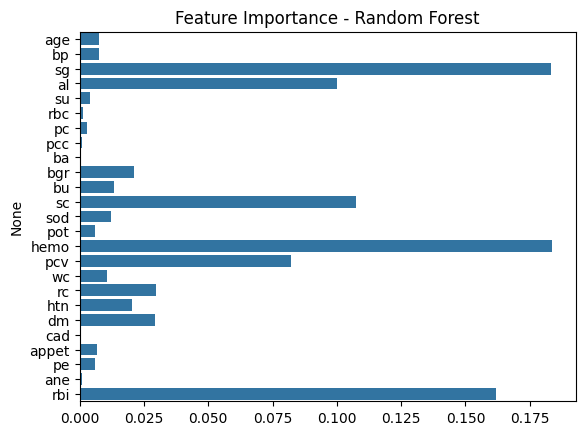

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp = model.feature_importances_
features = X.columns
sns.barplot(x=feature_imp, y=features)
plt.title("Feature Importance - Random Forest")
plt.show()